In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/ai/data/wuqiao/clinical_sample/WES/RAW_VCF/MT_analysis_2025.5.14_adjust_annotation/paired code and results_adjusted")

In [3]:
mutation=read.table("data/190 samples adjacent tumor paired exon mutation.csv",sep=",",quote = "\"",header=T)

In [4]:
print(head(mutation))

       ID        Sample    class  Chr Start End Ref        Alt
1 1288251 KY-WES-137045 adjacent chrM   567 567   A          C
2 1288251 KY-WES-137045 adjacent chrM   567 567   A          C
3 1288251 KY-WES-137045 adjacent chrM   567 567   A ACCCCCCCCC
4 1288251 KY-WES-137045 adjacent chrM   567 567   A ACCCCCCCCC
5 1288251 KY-WES-137045 adjacent chrM   310 310   T          C
6 1288251 KY-WES-137045 adjacent chrM   310 310   T          C
                                               Alt_all
1 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
2 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
3 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
4 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
5                                                 C,TC
6                                                 C,TC
               Mutation.Class Func.MT_ensGene Gene.MT_ensGene
1 Substitution (Transversion)        upstream            RNR1
2 Substitution (Transversion)        upstream     

In [5]:
# Step 1: 计算每个基因在每个样本中的突变数目

valid_genes <- mutation %>%
  filter(
    class == "tumor",
    !is.na(ExonicFunc.MT_ensGene),
    ExonicFunc.MT_ensGene != "",
    Gene.MT_ensGene != "missing"
  ) %>%
  pull(Gene.MT_ensGene) %>%
  unique()
mutation_counts <- mutation %>%
    filter(Gene.MT_ensGene %in% valid_genes) %>%
    group_by(Sample, Gene.MT_ensGene, class) %>%
    summarise(count = sum(ifelse(ExonicFunc.MT_ensGene == "", 0, 1)), .groups = 'drop')

In [6]:
valid_genes

[1] "COX1" "ND4"  "ATP6" "ND5"  "ND3"  "COX2" "ATP8" "ND1"  "COX3" "ND2" 
[11] "ND6"  "CYTB" "ND4L"

In [7]:
head(mutation_counts)

Sample,Gene.MT_ensGene,class,count
<chr>,<chr>,<chr>,<dbl>
KY-131729,ND6,tumor,2
KY-131732,CYTB,adjacent,0
KY-131733,ND5,tumor,1
KY-131734,CYTB,adjacent,0
KY-131735,ND2,tumor,1
KY-131735,ND3,tumor,2


In [ ]:
# Step 2:为每个基因再不同类别在每个样本中计算平均突变数和95%置信区间
summary_stats <- mutation_counts %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(count),
        ci_lower = avg_count - 1.96 * sd(count) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(count) / sqrt(n()),
        .groups = 'drop'
    )

In [16]:
# Step 3: 构建所有基因与 class 的组合，保留并集
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(mutation_counts$Gene.MT_ensGene[mutation_counts$Gene.MT_ensGene != "missing"]),
  class = unique(mutation_counts$class),
  stringsAsFactors = FALSE
)

# Step 4: 合并后缺失处为 NA
summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [17]:
print(summary_stats_complete)

   Gene.MT_ensGene    class avg_count    ci_lower  ci_upper
1              ND6    tumor 1.6666667  1.25346239 2.0798709
2             CYTB    tumor 1.6000000  1.22713363 1.9728664
3              ND5    tumor 1.3947368  1.12273033 1.6667434
4              ND2    tumor 1.0714286  0.93142857 1.2114286
5              ND3    tumor 1.6250000  1.10941780 2.1405822
6              ND1    tumor 1.5000000  0.99727061 2.0027294
7              ND4    tumor 2.3333333  1.47436237 3.1923043
8             COX2    tumor 1.1250000  0.88000000 1.3700000
9             ATP6    tumor 1.3333333  0.68000000 1.9866667
10            COX3    tumor 1.6000000  1.00121011 2.1987899
11            COX1    tumor 1.2500000  1.03086534 1.4691347
12            ND4L    tumor 1.3333333  0.68000000 1.9866667
13            ATP8    tumor 1.0000000          NA        NA
14             ND6 adjacent 2.0000000  2.00000000 2.0000000
15            CYTB adjacent 0.3333333  0.09715372 0.5695129
16             ND5 adjacent 1.2857143  0

In [18]:
write.table(summary_stats_complete,"data/mean mutation counts of each gene in paired each sample_exon gene.csv",sep=",",quote=F,row.names=F)

In [19]:
# 分别绘制 adjacent 类别的分布图
adjacent_stats <- summary_stats_complete %>% filter(class == "adjacent")

# 按照 avg_count 从大到小排序
adjacent_stats <- adjacent_stats %>%
  arrange(is.na(avg_count), desc(avg_count)) %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = Gene.MT_ensGene))

In [20]:
adjacent_stats

Gene.MT_ensGene,class,avg_count,ci_lower,ci_upper
<fct>,<chr>,<dbl>,<dbl>,<dbl>
ND6,adjacent,2.0000000,2.00000000,2.0000000
ND3,adjacent,2.0000000,0.92646379,3.0735362
ND4,adjacent,1.3333333,0.68000000,1.9866667
ND5,adjacent,1.2857143,0.92423584,1.6471927
ND2,adjacent,1.2857143,0.46141660,2.1100120
ND1,adjacent,1.0000000,1.00000000,1.0000000
ATP6,adjacent,1.0000000,0.62959482,1.3704052
COX3,adjacent,1.0000000,0.12346135,1.8765386
ND4L,adjacent,1.0000000,NA,NA


In [21]:
####tumor类别图
# 1. 获取 adjacent 中的 Gene.MT_ensGene 顺序
adjacent_levels <- adjacent_stats$Gene.MT_ensGene %>% as.character()

# 2. 设置 tumor_stats 中的 Gene.MT_ensGene 为 factor，并按照 adjacent 的顺序排列
tumor_stats <- summary_stats_complete %>%
  filter(class == "tumor") %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = adjacent_levels)) %>%
  arrange(Gene.MT_ensGene)

In [22]:
print(adjacent_stats)
print(tumor_stats)

   Gene.MT_ensGene    class avg_count    ci_lower  ci_upper
1              ND6 adjacent 2.0000000  2.00000000 2.0000000
2              ND3 adjacent 2.0000000  0.92646379 3.0735362
3              ND4 adjacent 1.3333333  0.68000000 1.9866667
4              ND5 adjacent 1.2857143  0.92423584 1.6471927
5              ND2 adjacent 1.2857143  0.46141660 2.1100120
6              ND1 adjacent 1.0000000  1.00000000 1.0000000
7             ATP6 adjacent 1.0000000  0.62959482 1.3704052
8             COX3 adjacent 1.0000000  0.12346135 1.8765386
9             ND4L adjacent 1.0000000          NA        NA
10            COX1 adjacent 0.7142857  0.00963450 1.4189369
11            ATP8 adjacent 0.6666667  0.01333333 1.3200000
12            COX2 adjacent 0.5000000 -0.48000000 1.4800000
13            CYTB adjacent 0.3333333  0.09715372 0.5695129
   Gene.MT_ensGene class avg_count  ci_lower ci_upper
1              ND6 tumor  1.666667 1.2534624 2.079871
2              ND3 tumor  1.625000 1.1094178 2.14058

In [23]:
# 计算全局的颜色范围和 X 轴范围
color_limits <- range(c(adjacent_stats$avg_count, tumor_stats$avg_count), na.rm = TRUE)
x_limits <- c(-0.5, 4)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


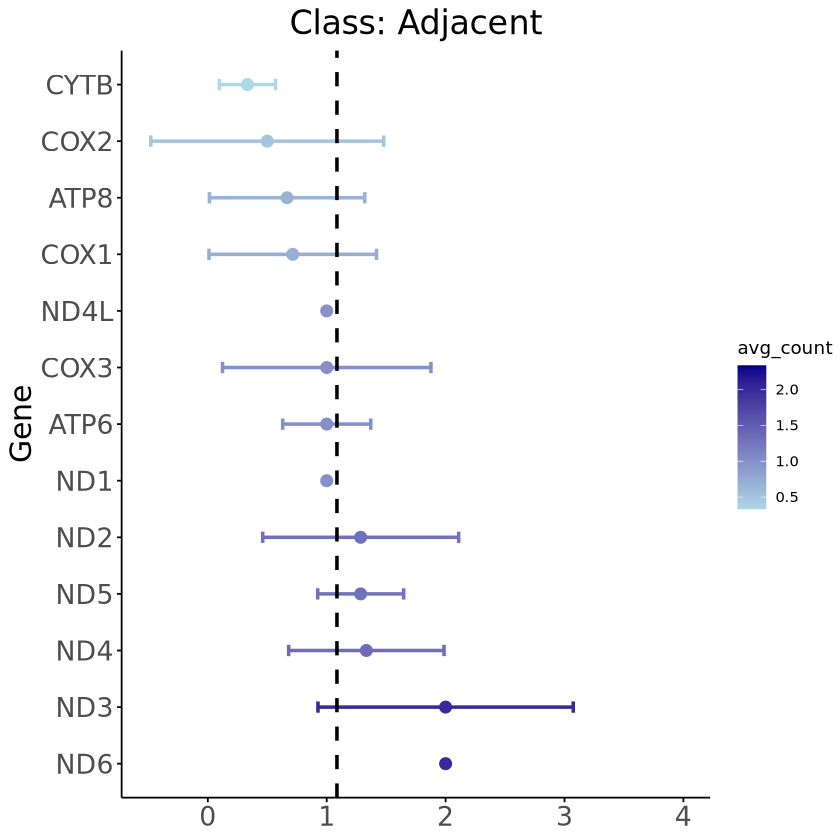

In [24]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +
     scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(adjacent_plot)

In [25]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +
     scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题



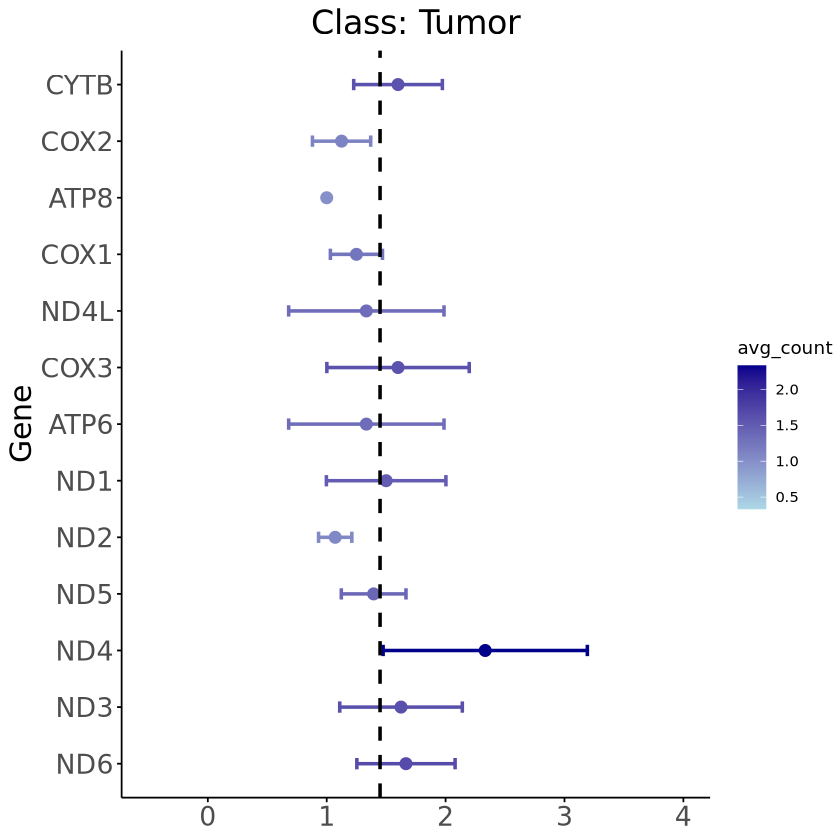

In [26]:
print(tumor_plot)

In [27]:
library(patchwork)

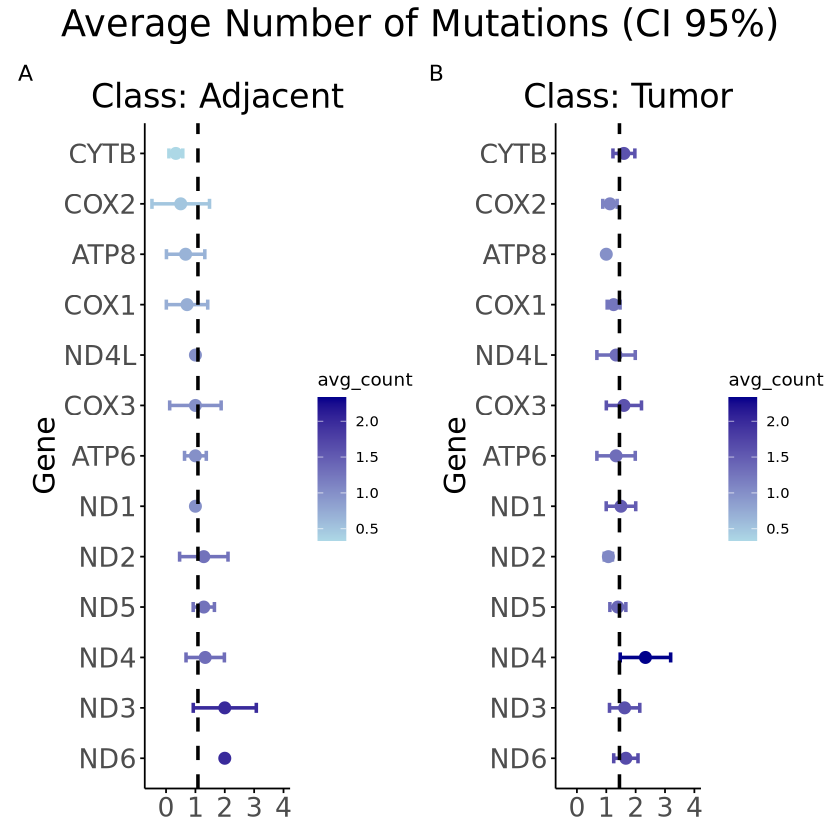

In [28]:

# 将两个图拼在一起，设置为一行
combined_plot <- (adjacent_plot | tumor_plot) +
    plot_layout(ncol = 2) +
    plot_annotation(title = "Average Number of Mutations (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))

# 添加一个共享的 X 轴标题
combined_plot <- combined_plot + 
    plot_annotation(tag_levels = 'A') +
    plot_layout(heights = c(1, 0)) +  # 调整高度
    labs(x = "Average Number of Mutations (CI 95%)")

print(combined_plot)

In [29]:
ggsave("plots/mutation count of per gene in one class paired exon gene.pdf", plot = combined_plot, width = 10, height = 5,dpi=300)